In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Isolated Model Simulation

In [19]:
def predict_simu(model, data_simu_x_n, data_simu_y, initial_capital):
    capital = initial_capital
    win_count = 0
    lost_count = 0
    no_order_count = 0
    record_result = []
    record_capital = []
    record_date = []
    consecutive_lost = 0
    consecutive_lost_max = 0
    for i in range(0, len(data_simu_x_n)):
        prediction = model.predict(data_simu_x_n.iloc[i].values.reshape(1,-1))
        
        if prediction == 1 and data_simu_y[i] == 1:
            outcome = 3
            capital += outcome
            win_count += 1
            order_record = 'win-------- prediction = {0}, actual = {1}'.format(prediction,data_simu_y[i])
            result = 'win'
        elif prediction == 1 and data_simu_y[i] == 0:
            outcome = -3.3
            capital += outcome
            lost_count += 1
            order_record = 'lost------- prediction = {0}, actual = {1}'.format(prediction,data_simu_y[i])
            result = 'lost'
        elif prediction == 0:
            no_order_count +=1
            order_record = 'no order--- prediction = {0}, actual = {1}'.format(prediction, data_simu_y[i])
            capital = capital
            result = 'no order'
        else:
            raise ValueError('no condition met')
        record_date.append(data_simu_x_n.iloc[i].name)
        record_result.append(order_record)
        record_capital.append(capital)

        #Calculate Consecutive Lost
        if result == 'lost':
            consecutive_lost += -3.3
            if consecutive_lost <= consecutive_lost_max:
                consecutive_lost_max = consecutive_lost
        if result == 'win':
            if consecutive_lost <= consecutive_lost_max:
                consecutive_lost_max = consecutive_lost
            consecutive_lost = 0

    total_return = ((capital - initial_capital) / initial_capital)*100
    sim_df = pd.DataFrame({'record_date':record_date,
                           'record_result':record_result,
                           'record_capital': record_capital})
    sim_df.set_index('record_date', inplace=True)

    return win_count, lost_count, no_order_count, capital, total_return, sim_df, consecutive_lost_max


# Define Combine Simulation

In [2]:
def predict_simu_combine(model_long, 
                         data_simu_x_n_long, 
                         data_simu_y_long, 
                         model_short, 
                         data_simu_x_n_short, 
                         data_simu_y_short, 
                         initial_capital):
    capital = initial_capital
    win_count = 0
    lost_count = 0
    no_order_count = 0
    record_result = []
    record_capital = []
    record_date = []
    consecutive_lost = 0
    consecutive_lost_max = 0
    result_one_one = 0
    for i in range(0, len(data_simu_x_n_long)):
        prediction_long = model_long.predict(data_simu_x_n_long.iloc[i].values.reshape(1,-1))
        prediction_short = model_short.predict(data_simu_x_n_short.iloc[i].values.reshape(1,-1))
        
        # if prediction_long ==1 and prediction_short == 1
        #     no trade
        # if prediction_long == 1 and prediction_short ==0
        #     trade long
        # if prediction_long ==0 and prediction_short == 1
        #     trade short
        # if prediction_long == 0 and prediction_short ==0
        #     no trade
        if prediction_long ==1 and prediction_short == 1:
            no_order_count +=1
            order_record = 'no order--- p_long = {0}, p_short = {1},  actual = {2}, model = {3}'.format(prediction_long, prediction_short,data_simu_y_long[i],'None')
            capital = capital
            result = 'no order'
            result_one_one += 1
        elif prediction_long == 1 and prediction_short == 0 and data_simu_y_long[i] == 1:
            outcome = 3
            capital += outcome
            win_count += 1
            order_record = 'win-------- p_long = {0},p_short = {1}, actual = {2}, model = {3}'.format(prediction_long, prediction_short,data_simu_y_long[i],'Long')
            result = 'win'
        elif prediction_long == 1 and prediction_short == 0 and data_simu_y_long[i] == 0:
            outcome = -3.3
            capital += outcome
            lost_count += 1
            order_record = 'lost------- p_long = {0},p_short = {1}, actual = {2}, model = {3}'.format(prediction_long, prediction_short,data_simu_y_long[i],'Long')
            result = 'lost'
        elif prediction_long == 0 and prediction_short == 1 and data_simu_y_short[i] == 1:
            outcome = 3
            capital += outcome
            win_count += 1
            order_record = 'win-------- p_long = {0},p_short = {1}, actual = {2}, model = {3}'.format(prediction_long, prediction_short,data_simu_y_long[i],'Long')
            result = 'win'
        elif prediction_long == 0 and prediction_short == 1 and data_simu_y_short[i] == 0:
            outcome = -3.3
            capital += outcome
            lost_count += 1
            order_record = 'lost------- p_long = {0},p_short = {1}, actual = {2}, model = {3}'.format(prediction_long, prediction_short,data_simu_y_long[i],'Long')
            result = 'lost'
        elif prediction_long == 0 and prediction_short == 0:
            no_order_count +=1
            order_record = 'no order--- p_long = {0}, p_short = {1},  actual = {2}, model = {3}'.format(prediction_long, prediction_short, data_simu_y_long[i],'None')
            capital = capital
            result = 'no order'
        else:
            raise ValueError('no condition met')
        record_date.append(data_simu_x_n_long.iloc[i].name)
        record_result.append(order_record)
        record_capital.append(capital)

        #Calculate Consecutive Lost
        if result == 'lost':
            consecutive_lost += -3.3
            if consecutive_lost <= consecutive_lost_max:
                consecutive_lost_max = consecutive_lost
        if result == 'win':
            if consecutive_lost <= consecutive_lost_max:
                consecutive_lost_max = consecutive_lost
            consecutive_lost = 0

    total_return = ((capital - initial_capital) / initial_capital)*100
    sim_df = pd.DataFrame({'record_date':record_date,
                           'record_result':record_result,
                           'record_capital': record_capital})
    sim_df.set_index('record_date', inplace=True)

    return win_count, lost_count, no_order_count, capital, total_return, sim_df, consecutive_lost_max, result_one_one


In [4]:
pd.read_csv('X_long_simu.csv')

,datetime,open,high,low,close
0,2022-10-28 12:00:00,-2.839808,-2.806494,-2.828501,-2.791640
1,2022-10-28 13:00:00,-2.791894,-2.785265,-2.799430,-2.815290
2,2022-10-28 14:00:00,-2.815696,-2.802956,-2.798498,-2.784220
3,2022-10-28 15:00:00,-2.784939,-2.774651,-2.769146,-2.753305
4,2022-10-28 16:00:00,-2.754954,-2.767728,-2.756405,-2.761806
...,...,...,...,...,...
1898,2023-02-28 12:00:00,0.051565,0.085802,0.085470,0.092761
1899,2023-02-28 14:00:00,0.074131,0.073080,0.110222,0.088850
1900,2023-02-28 16:00:00,0.049355,0.028884,0.070880,0.053807
1901,2023-02-28 18:00:00,0.045167,0.026930,0.070087,0.034439


In [3]:
import pickle

lsvm_long = pickle.load(open('lsvm_xauusd.pkl','rb'))
y_test_long = np.loadtxt('y_long_simu.csv', delimiter=',')
X_test_simu_n_long = pd.read_csv('X_long_simu.csv',index_col='datetime', parse_dates=True)

lsvm_short = pickle.load(open('lsvm_xauusd_short.pkl','rb'))
y_test_short = np.loadtxt('y_short_simu.csv', delimiter=',')
X_test_simu_n_short = pd.read_csv('X_short_simu.csv',index_col='datetime', parse_dates=True)

win_count, lost_count, no_order_count, capital, total_return, sim_df, consecutive_lost_max, result_one_one = predict_simu_combine(lsvm_long, X_test_simu_n_long, y_test_long, lsvm_short, X_test_simu_n_short, y_test_short, 500)                                                          
print('Total Return: {0}%'.format(round(total_return,0)))
print('Final Capital: ${0}'.format(round(capital,0)))
print('Win Count: ',win_count)
print('Lost Count: ',lost_count)
print('No Order Count: ', no_order_count)
print('Max Consecutive Lost: {0} trades'.format(consecutive_lost_max/-3.3))
day_one = X_test_simu_n_short.iloc[0].name.to_pydatetime().date()
day_final = X_test_simu_n_short.iloc[len(X_test_simu_n_short)-1].name.to_pydatetime().date()
print('Total day on trading: {0} days'.format((day_final - day_one).days))
print('result one one',result_one_one)
# sim_df.plot(y='record_capital')

c:\Users\pkong\LSVM-XAUUSD\venv\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LinearSVC from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Total Return: 158.0%
Final Capital: $1292.0
Win Count:  429
Lost Count:  150
No Order Count:  1324
Max Consecutive Lost: 4.0 trades
Total day on trading: 123 days
result one one 0


In [32]:
sim_df.to_csv('sim_df.csv')

# Short Model Import

Total Return: 74.0%
Final Capital: $871.0
Win Count:  192
Lost Count:  62
No Order Count:  1649
Max Consecutive Lost: 4.0 trades
Total day on trading: 123 days


<Axes: xlabel='record_date'>

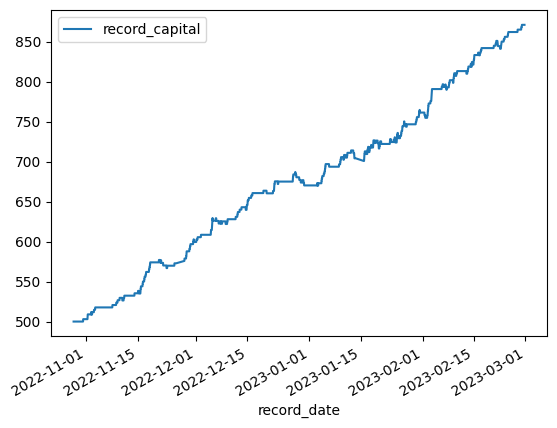

In [22]:
import pickle
lsvm_short = pickle.load(open('lsvm_xauusd_short.pkl','rb'))


y_test_short = np.loadtxt('y_short_simu.csv', delimiter=',')
X_test_simu_n_short = pd.read_csv('X_short_simu.csv',index_col='datetime', parse_dates=True)

win_count, lost_count, no_order_count, capital, total_return, sim_df, consecutive_lost_max = predict_simu(lsvm_short, X_test_simu_n_short, y_test_short, 500)                                                          
print('Total Return: {0}%'.format(round(total_return,0)))
print('Final Capital: ${0}'.format(round(capital,0)))
print('Win Count: ',win_count)
print('Lost Count: ',lost_count)
print('No Order Count: ', no_order_count)
print('Max Consecutive Lost: {0} trades'.format(consecutive_lost_max/-3.3))
day_one = X_test_simu_n_short.iloc[0].name.to_pydatetime().date()
day_final = X_test_simu_n_short.iloc[len(X_test_simu_n_short)-1].name.to_pydatetime().date()
print('Total day on trading: {0} days'.format((day_final - day_one).days))
sim_df.plot(y='record_capital')

# Long Model Import

c:\Users\pkong\LSVM-XAUUSD\venv\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LinearSVC from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Total Return: 84.0%
Final Capital: $921.0
Win Count:  237
Lost Count:  88
No Order Count:  1578
Max Consecutive Lost: 5.0 trades
Total day on trading: 123 days


<Axes: xlabel='record_date'>

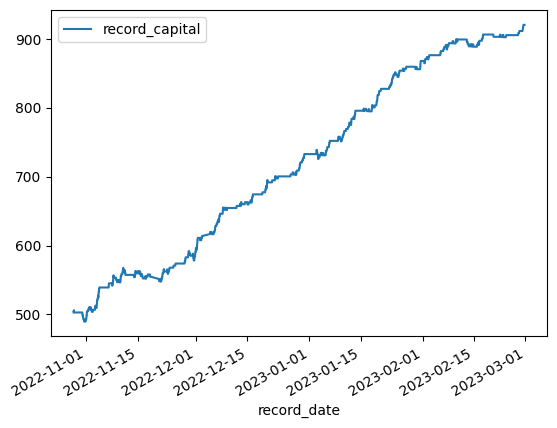

In [33]:
import pickle
lsvm_long = pickle.load(open('lsvm_xauusd.pkl','rb'))


y_test_long = np.loadtxt('y_long_simu.csv', delimiter=',')
X_test_simu_n_long = pd.read_csv('X_long_simu.csv',index_col='datetime', parse_dates=True)

win_count, lost_count, no_order_count, capital, total_return, sim_df, consecutive_lost_max = predict_simu(lsvm_long, X_test_simu_n_long, y_test_long, 500)                                                          
print('Total Return: {0}%'.format(round(total_return,0)))
print('Final Capital: ${0}'.format(round(capital,0)))
print('Win Count: ',win_count)
print('Lost Count: ',lost_count)
print('No Order Count: ', no_order_count)
print('Max Consecutive Lost: {0} trades'.format(consecutive_lost_max/-3.3))
day_one = X_test_simu_n_short.iloc[0].name.to_pydatetime().date()
day_final = X_test_simu_n_short.iloc[len(X_test_simu_n_short)-1].name.to_pydatetime().date()
print('Total day on trading: {0} days'.format((day_final - day_one).days))
sim_df.plot(y='record_capital')